# Metriken Lösung

### Module importieren

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
pd.set_option('display.max_columns', 31)

### Daten einlesen

Der verwendete Datensatz enthält Kreditkartentransaktionen die innerhalb der Variable `class` mit 1 gekennzeichnet sind, wenn es sich um einen Betrugsfall handelt. `time` gibt in Sekunden den Abstand zum Beginn des Beobachtungszeitraums an und `amount` die Höhe der Transaktion. 

In [3]:
# adjust to correct path if necessary
creditcard_df = pd.read_csv('credit_card_fraud.csv'))

### Überblick über Daten bekommen

In [4]:
creditcard_df.head()

,time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Bis auf `time` und `amount` wurden alle Variablen durch Principale Component Analysis gewonnen (PCA) um Anonymität zu gewährleisten. Das erklärt Durchschnittswerte von 0 und die abnehmenden Standardabweichungen.

In [5]:
creditcard_df.describe().round(2)

,time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


### Daten vorbereiten

In [6]:
X = creditcard_df.loc[:, 'time':'amount'].values
y = creditcard_df['class'].values

In [7]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0) 

train_id, test_id = next(strat_split.split(X, y))
X_train, X_test, y_train, y_test = X[train_id], X[test_id], y[train_id], y[test_id]

In [8]:
scaler = StandardScaler()

In [9]:
# standardizing values for logistic regression for faster conversion
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modelle trainieren und Vorhersagen erstellen

#### Logistic Regression

In [10]:
lr_model = LogisticRegression()

In [11]:
lr_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [12]:
# save probility estimates of model
y_pred_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

#### Random Forest

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=50)

In [26]:
np.random.seed(7)
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=50)

In [27]:
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

#### Baseline

Als Baseline wählen wir einfach die häufigste Ausprägung der Zielvariable: 0

In [28]:
y_baseline = np.zeros(y_test.size)

### Validierung

Nun sind Sie gefragt. Berechnen Sie nachfolgend die gefragten Metriken und vergleichen Sie die Modelle miteinander und der Baseline. 

Übersichtstabelle:
|True / Pred          |  Negative  |  Positive  |
| ---      |    :---:   |    :---:   |
| Negative |     TN     |     FP     |
| Positive |     FN     |     TP     |

In [29]:
predictions = {'lr': y_pred_lr, 'rf': y_pred_rf, 'baseline': y_baseline}

#### 1. Accuracy

Nutzen Sie die `accuracy_score` Funktion zum Berechnen der Accuracy. Beachten Sie, dass diese Funktion KLassen, also ganze Zahlen, als Inputs benötigt. Vergleichen Sie anschließend die Scores der verschiedenen Vorhersagen. Wie aussagekräftig sind sie? 
$$ Accuracy = \frac{True \: Values}{All \: Values} $$

In [30]:
acc_scores = {model: accuracy_score(y_test, y_pred.round()).round(6) for model, y_pred in predictions.items()}
acc_scores

{'lr': 0.999184, 'rf': 0.999333, 'baseline': 0.998271}

Da die überwältigende Mehrheit der Werte 0 ist, sagen Modelle und Baseline in den meisten oder allen Fällen auch 0 vorher. Da die Accuracy nicht zwischen negativen und positiven Werten bzw. 0 und 1 unterscheidet, sondern nur alle richtig vorhergesagten Werte mit der Gesamtzahl an Werten ins Verhältnis setzt, liegen die Scores der verschiedenen Methoden sehr nah bei einander. Daran kann man sehen, dass Accuracy keine geeignete Metrik bei einer unsymetrischen Verteilung der Zielvariablenwerte ist.  

In [31]:
# alternative:
# acc_lr = accuracy_score(y_test, y_pred_lr.round())
# print(acc_lr.round(6))

# acc_rf = accuracy_score(y_test, y_pred_rf.round())
# print(acc_rf.round(6))

# acc_baseline = accuracy_score(y_test, y_baseline)
# print(acc_baseline.round(6))


#### 2. Area under the ROC curve (AUC)

2.1 Die ROC (Receiver Operating Characteristic) Curve zeichnet für jeden KLassifizierungsschwellenwert die True-Positive-Rate (TPR, auch Recall genannt) und die False-Positive-Rate (FPR) in einen Graphen. Die Area Under the Curve (AUC) berechnet dann die Fläche unter der Kurve, die ein Maxium von 1 hat und bei Zufallswerten den Wert 0.5 erreicht. Im Gegensatz zu den anderen präsentierten Metriken, verwendet die AUC die Wahrscheinlichkeitsschätzungen und nicht die daraus folgenden KLassen.

Berechnen Sie mit Hilfe der Funktion `roc_auc_score` die AUC für alle 3 Vorhersagen. Welche Unterschiede bemerken Sie?
$$ TPR = \frac{TP}{TP + FN} $$ 
$$ FPR = \frac{FP}{FP + TN} $$

In [32]:
auc_scores = {model: roc_auc_score(y_test, y_pred).round(6) for model, y_pred in predictions.items()}
auc_scores

{'lr': 0.97128, 'rf': 0.969474, 'baseline': 0.5}

Im Gegensatz zur Accuracy Metrik, schneidet die Baseline hier deutlich schlechter ab.

In [ ]:
# alternative:
# auc_lr = roc_auc_score(y_test, y_pred_lr)
# print(auc_lr.round(6))

# auc_rf = roc_auc_score(y_test, y_pred_rf)
# print(auc_rf.round(6))

# auc_baseline = roc_auc_score(y_test, y_baseline)
# print(auc_baseline.round(6))

2.2 Versuchen Sie auch die ROC Curve zu plotten. Mit `roc_curve` lassen sich die FPR und TPR Werte berechnen und dann mit `plt.plot` plotten.

In [33]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

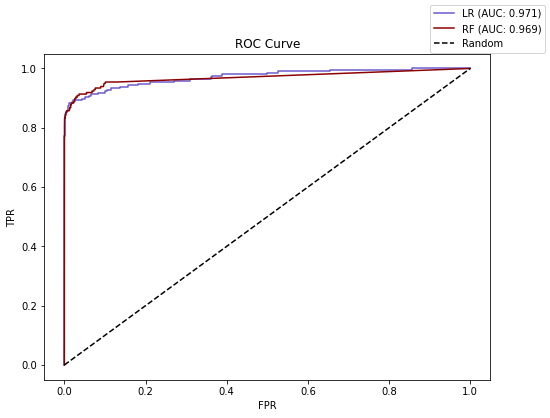

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(fpr_lr, tpr_lr, color='slateblue', label=f'LR (AUC: {auc_scores["lr"].round(3)})')
ax.plot(fpr_rf, tpr_rf, color='darkred', label=f'RF (AUC: {auc_scores["rf"].round(3)})')
ax.plot([0,1], [0,1], color='black', linestyle='dashed', label='Random')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve')
fig.legend()
plt.show()

#### 3. Precission

Precission (dt. Genauigkeit) gibt den Anteil relevanter positver Klassifizierungen (TP) an allen positiv klassifizierten Elementen an.

Nutzen Sie die Funktion `precision_score` um die Precision zu berechnen. Achten Sie dabei darauf, dass hier wieder Klassen und keine Wahrscheinlichkeitswerte gefragt sind.
$$ Precission = \frac{TP}{TP + FP} $$

In [36]:
precision_scores = {model: precision_score(y_test, y_pred.round()).round(6) for model, y_pred in predictions.items()}
precision_scores

/home/tokr/miniconda3/envs/standard_ds/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'lr': 0.871429, 'rf': 0.871166, 'baseline': 0.0}

In [37]:
# alternative:
# precision_lr = precision_score(y_test, y_pred_lr.round())
# print(precision_lr.round(6))

# precision_rf = precision_score(y_test, y_pred_rf.round())
# print(precision_rf.round(6))

# precision_baseline = precision_score(y_test, y_baseline)
# print(precision_baseline.round(6))

#### 4. Recall

Recall (dt. Trefferquote) gibt den Anteil relevanter positiver Klassifizierungen an allen tatsächlich positiven Elementen an.

Nutzen Sie die Funktion `recall_score` um den Recall zu berechnen.
$$ Recall = \frac{TP}{TP + FN} $$ 

In [38]:
recall_scores = {model: recall_score(y_test, y_pred.round()).round(6) for model, y_pred in predictions.items()}
recall_scores

{'lr': 0.619289, 'rf': 0.720812, 'baseline': 0.0}

In [39]:
# alternative:
# recall_lr = recall_score(y_test, y_pred_lr.round())
# print(recall_lr.round(6))

# recall_rf = recall_score(y_test, y_pred_rf.round())
# print(recall_rf.round(6))

# recall_baseline = precision_score(y_test, y_baseline)
# print(recall_baseline.round(6))

#### 5. F1-Score

Der F1-Score kombiniert Precision und Recall in einer Metrik.

Berechnen Sie den F1-Score mit Hilfe der Funktion `f1_score`. 

$$ F1 \, Score = 2 * \frac{precision * recall}{precision + recall} $$

In [40]:
f1_scores = {model: f1_score(y_test, y_pred.round()).round(6) for model, y_pred in predictions.items()}
f1_scores

{'lr': 0.724036, 'rf': 0.788889, 'baseline': 0.0}

In [41]:
# alternative:
# f1_lr = f1_score(y_test, y_pred_lr.round())
# print(f1_lr.round(6))

# f1_rf = f1_score(y_test, y_pred_rf.round())
# print(f1_rf.round(6))

# f1_baseline = f1_score(y_test, y_baseline)
# print(f1_baseline.round(6))

#### 6. Confusion Matrix

Eine weitere Methode Ergebnisse zu  betrachten, ist die Confusion Matrix. Sie bietet eine Möglichkeit die Anzahl an TruePositive, FalsePositive, TrueNegative und FalseNegative Werten auf einen Blick miteinander zu vergleichen. Verwenden Sie die `confusion_matrix` Funktion um sie zu berechnen.

In [45]:
print('------- Logistic Regression -------')
confusion_matrix_lr = pd.DataFrame(confusion_matrix(y_test, y_pred_lr.round()), index=['true 0', 'true 1'], columns=['predicted 0', 'predicted 1'])
print(confusion_matrix_lr)

print('---------- Random Forest ----------')
confusion_matrix_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf.round()), index=['true 0', 'true 1'], columns=['predicted 0', 'predicted 1'])
print(confusion_matrix_rf)

print('------------ Baseline  ------------')
confusion_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_baseline.round()), index=['true 0', 'true 1'], columns=['predicted 0', 'predicted 1'])
print(confusion_matrix_baseline)

------- Logistic Regression -------
        predicted 0  predicted 1
true 0       113708           18
true 1           75          122
---------- Random Forest ----------
        predicted 0  predicted 1
true 0       113705           21
true 1           55          142
------------ Baseline  ------------
        predicted 0  predicted 1
true 0       113726            0
true 1          197            0


#### 7. Abschließender Vergleich

Vergleichen Sie nun noch einmal die Werte aller Metriken miteinander. Welches Modell würden Sie wählen?

In [43]:
model_metrics_comparison = pd.DataFrame({'acc': acc_scores, 'auc': auc_scores, 'precision': precision_scores, 'recall': recall_scores, 'f1-score': f1_scores })
model_metrics_comparison

,acc,auc,precision,recall,f1-score
lr,0.999184,0.971280,0.871429,0.619289,0.724036
rf,0.999333,0.969474,0.871166,0.720812,0.788889
baseline,0.998271,0.500000,0.000000,0.000000,0.000000


Was Accuracy, AUC und Precision angeht, gleichen sich die Ergebnisse beider Modelle recht stark. Der große Unterschied liegt im Recall und darauß folgend auch dem F1-Score. Da es für eine Bank wichtig ist möglichst viele Betrugsfälle zu finden, scheint es logisch das Random Forest Modell zu wählen, das mehr der Betrugsfälle findet als die Logistic Regression. Dies lässt sich auch aus dem True Positive Feld der Confusion Matrix erkennen. Allerdings kann es auch Gründe geben trotzdem sich für die Logistic Regression zu entscheide. Bspw. benötigt das Training der LR nur einen Bruchteil der Zeit des Trainings eines RF-Modells, was bei noch deutlich größeren Datensätzen von Relevanz sein kann. 

Beachten Sie auch, dass wir der Einfachheit halber hier einige Aspekte ignorieren. Bspw. wird in diesen Kontexten häufig mit Kostenfunktionen gearbeitet die Klassifizierungen mit unterschiedlichen Kosten gewichten. Außerdem könnte man insbesondere den Recall Score dadurch beeinflussen, dass man Wahrscheinlichkeitsschätzwerte nicht, wie hier getan, bei 0.5 sondern einer niedrigeren Stelle aufrundet. Dies müsste dann allerdings mit einem extra Testset kalibriert werden.  